In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 保证图表美观
sns.set(style="whitegrid", context="talk")

# 载入数据
df = pd.read_csv("data/raw/etf_SPY_daily.csv", parse_dates=["Date"]).sort_values("Date")
df.head()

,Date,Close_SPY,High_SPY,Low_SPY,Open_SPY,Volume_SPY
0,2010-01-04,85.515633,85.560905,84.142312,84.791244,118944600
1,2010-01-05,85.742012,85.779743,85.153447,85.462824,111579900
2,2010-01-06,85.802383,86.013663,85.591104,85.659013,116074400
3,2010-01-07,86.164581,86.270221,85.402462,85.643925,131091100
4,2010-01-08,86.451332,86.489063,85.764674,85.938223,126402800


In [4]:
df["ret1"] = df["Close_SPY"].pct_change()
df["ret_fwd1"] = df["ret1"].shift(-1)
df[["Date","Close_SPY","ret1","ret_fwd1"]].head()                      

,Date,Close_SPY,ret1,ret_fwd1
0,2010-01-04,85.515633,NaN,0.002647
1,2010-01-05,85.742012,0.002647,0.000704
2,2010-01-06,85.802383,0.000704,0.004221
3,2010-01-07,86.164581,0.004221,0.003328
4,2010-01-08,86.451332,0.003328,0.001396


#### Feature 1 — 20‑day return momentum (`mom20`)
*What it is:* rolling mean of daily returns over the past 20 trading days.  
*Why:* a simple time‑series momentum proxy; if recent returns were positive on average, next‑day returns may tilt positive (momentum continuation).

#### Feature 2 — 20‑day realized volatility (`vol20`)
*What it is:* rolling standard deviation of daily returns over the past 20 days.  
*Why:* volatility clustering is common; high volatility clusters may coincide with different return regimes (risk‑on/off). Even if predictive power is weak, it’s a valuable risk feature and helps diagnose heteroskedasticity.

In [5]:
WINDOW = 20

# momentum proxy: rolling mean of returns
df["mom20"] = df["ret1"].rolling(WINDOW).mean()

# realized volatility: rolling std of returns
df["vol20"] = df["ret1"].rolling(WINDOW).std()

# keep aligned, drop rows where features/target are NA
feat_cols = ["mom20", "vol20"]
use = df[["Date","ret1","ret_fwd1"] + feat_cols].dropna().copy()
use.head(), use.shape

(         Date      ret1  ret_fwd1     mom20     vol20
 20 2010-02-02  0.012103 -0.004983 -0.001264  0.010585
 21 2010-02-03 -0.004983 -0.030866 -0.001646  0.010574
 22 2010-02-04 -0.030866  0.002067 -0.003224  0.012403
 23 2010-02-05  0.002067 -0.007219 -0.003332  0.012344
 24 2010-02-08 -0.007219  0.012560 -0.003860  0.012270,
 (3913, 5))

In [6]:
print("=== .describe() for new features ===")
print(use[feat_cols].describe().T)

print("\n=== Missing counts (post-dropna) ===")
print(use[["ret_fwd1"] + feat_cols].isna().sum())

=== .describe() for new features ===
        count      mean       std       min       25%       50%       75%  \
mom20  3913.0  0.000575  0.002104 -0.017082 -0.000368  0.000862  0.001788   
vol20  3913.0  0.009308  0.005858  0.002010  0.005806  0.007807  0.011104   

            max  
mom20  0.011005  
vol20  0.058701  

=== Missing counts (post-dropna) ===
ret_fwd1    0
mom20       0
vol20       0
dtype: int64


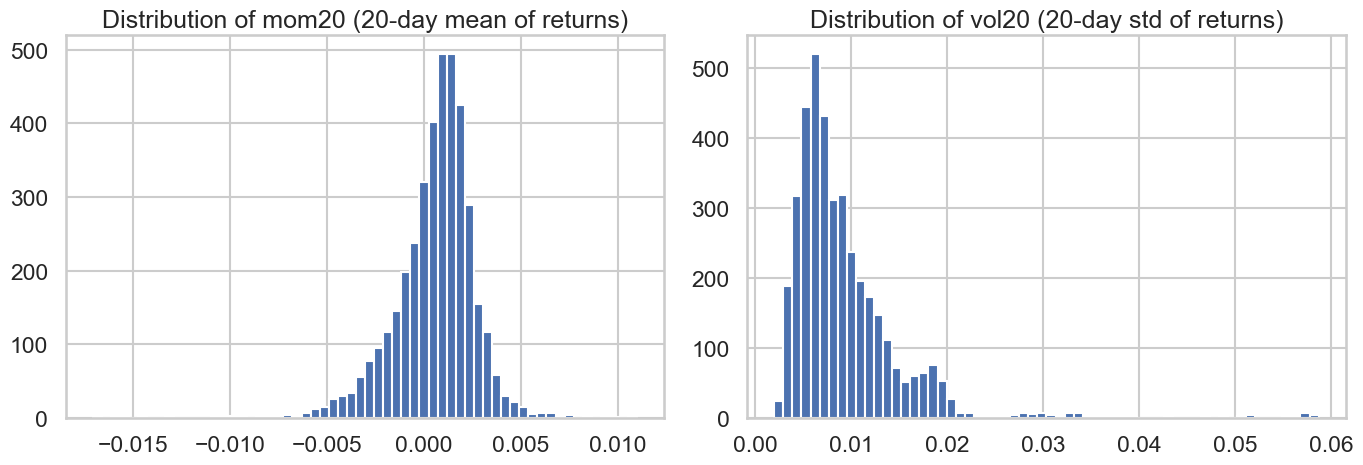

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14,5))
axes[0].hist(use["mom20"], bins=60)
axes[0].set_title("Distribution of mom20 (20-day mean of returns)")
axes[1].hist(use["vol20"], bins=60)
axes[1].set_title("Distribution of vol20 (20-day std of returns)")
plt.tight_layout()
plt.show()

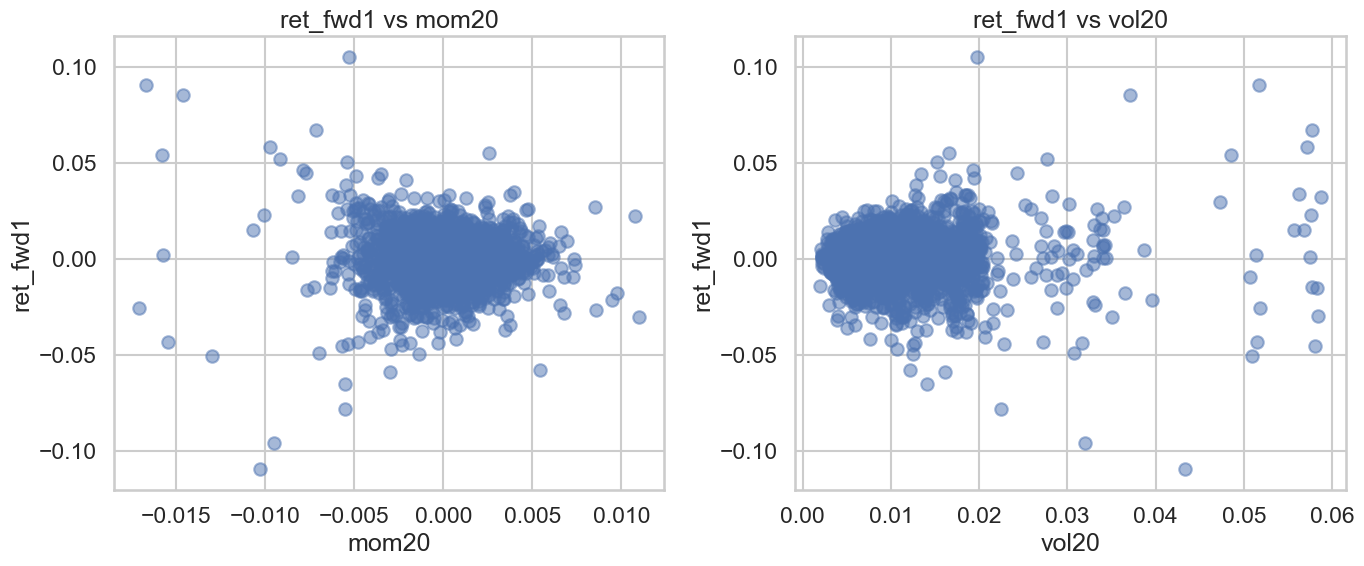

Pearson corr with ret_fwd1:
        pearson
mom20 -0.044026
vol20  0.029432

Spearman corr with ret_fwd1:
       spearman
mom20 -0.031488
vol20  0.037340


In [8]:
# scatter vs target
fig, axes = plt.subplots(1, 2, figsize=(14,6))
axes[0].scatter(use["mom20"], use["ret_fwd1"], alpha=0.5)
axes[0].set_title("ret_fwd1 vs mom20")
axes[0].set_xlabel("mom20"); axes[0].set_ylabel("ret_fwd1")

axes[1].scatter(use["vol20"], use["ret_fwd1"], alpha=0.5)
axes[1].set_title("ret_fwd1 vs vol20")
axes[1].set_xlabel("vol20"); axes[1].set_ylabel("ret_fwd1")

plt.tight_layout(); plt.show()

# correlation table
corr_pearson = use[["ret_fwd1","mom20","vol20"]].corr(method="pearson").loc[["mom20","vol20"], "ret_fwd1"]
corr_spearman = use[["ret_fwd1","mom20","vol20"]].corr(method="spearman").loc[["mom20","vol20"], "ret_fwd1"]

print("Pearson corr with ret_fwd1:")
print(corr_pearson.to_frame("pearson"))
print("\nSpearman corr with ret_fwd1:")
print(corr_spearman.to_frame("spearman"))

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

def fit_uni(x_col):
    X = use[[x_col]].values
    y = use["ret_fwd1"].values
    m = LinearRegression().fit(X, y)
    pred = m.predict(X)
    return {
        "x": x_col,
        "coef": float(m.coef_[0]),
        "intercept": float(m.intercept_),
        "R2": float(r2_score(y, pred)),
        "MAE": float(mean_absolute_error(y, pred)),
        "n": int(len(y))
    }

results = pd.DataFrame([fit_uni("mom20"), fit_uni("vol20")])
results

,x,coef,intercept,R2,MAE,n
0,mom20,-0.228363,0.000714,0.001938,0.007195,3913
1,vol20,0.054837,0.000073,0.000866,0.007195,3913


**Skew / Outliers / Structure**
- `vol20` is strictly non‑negative and right‑skewed (typical for volatility).  
- `mom20` is centered near zero with thinner range than raw `ret1` (smoothing effect).  
- Scatter plots suggest weak linear predictability of `ret_fwd1` from either `mom20` or `vol20` (cloud‑like pattern).  
- Correlations are expected to be small in daily equity data; any signal tends to be weak and noisy.

**Takeaways for next step**
- Try different momentum horizons: 5/20/60‑day (`rolling mean of ret1` or cumulative price momentum `P_t/P_{t-L} - 1`).  
- Add **volatility-aware** features: rolling **median** return (robust), **downside volatility** (std of negative returns), or **ret1 z‑score** = (ret1 − mean)/std over a window.  
- Consider **interaction or regime** ideas: e.g., momentum signal interacted with low‑vol regimes.  
- For modeling, use **walk‑forward splits** (time‑series cross‑validation) to avoid look‑ahead bias and get realistic performance estimates.